In [1]:
# import standard python libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from coolpuppy.lib import io

In [2]:
os.chdir("/path/")

In [3]:
pup_data = io.load_pileup_df("Hsieh_mESCs_microC.mm10.mapq_30.1000_mm10-cCREs_ESC_DNase_merged5kb_mm10.bed_expected_noflank_10kbres_100kbto10Mb_stripe.clpy")

In [4]:
pup_data = pup_data[pup_data["separation"] != "all"]

In [5]:
contact_freq = pd.DataFrame({"chrom": [item[0] for sublist in pup_data["coordinates"] for item in sublist],
                             "start1": [int(item[1]) for sublist in pup_data["coordinates"] for item in sublist],
                             "end1": [int(item[2]) for sublist in pup_data["coordinates"] for item in sublist],
                             "start2": [int(item[4]) for sublist in pup_data["coordinates"] for item in sublist],
                             "end2": [int(item[5]) for sublist in pup_data["coordinates"] for item in sublist],
                             "distance_band": ''.join([str(item)*pup_data.loc[pup_data["distance_band"] == item, "vertical_stripe"].reset_index(drop=True)[0].shape[0] for item in pup_data["distance_band"]]).split(")("),                    
                             "contact": [item[0] for sublist in pup_data["vertical_stripe"] for item in sublist]})

In [6]:
contact_freq["distance_band"] = contact_freq["distance_band"].str.replace('(','', regex=False)
contact_freq["distance_band"] = contact_freq["distance_band"].str.replace(')','', regex=False)
contact_freq["coord1"] = contact_freq["chrom"] + "_" + contact_freq["start1"].astype(str) + "_" + contact_freq["end1"].astype(str)
contact_freq["coord2"] = contact_freq["chrom"] + "_" + contact_freq["start2"].astype(str) + "_" + contact_freq["end2"].astype(str)
contact_freq = contact_freq.dropna()

In [7]:
contact_freq["log2_contact"] = np.log2(contact_freq["contact"]+1)

In [8]:
cistrome_remap = pd.read_csv("m10-cCREs_ESC_DNase_merged5kb_mm10_cistromeDB_ReMap2020_filtered.bed", 
                             sep="\t", 
                             dtype={"chrom_cres": str, "start_cres": int, 
                                    "end_cres": int, "ID": str})

In [9]:
n_overlap_1 = pd.DataFrame(cistrome_remap.groupby(["coords_cre", "Factor"]).size().groupby("coords_cre").size()).reset_index()
n_overlap_1.columns = ["coord1", "n_overlap_1"]
n_overlap_2 = pd.DataFrame(cistrome_remap.groupby(["coords_cre", "Factor"]).size().groupby("coords_cre").size()).reset_index()
n_overlap_2.columns = ["coord2", "n_overlap_2"]
n_overlap = pd.concat([n_overlap_1, n_overlap_2], axis=1)

In [10]:
overlaps_short = pd.merge(pd.merge(contact_freq.loc[contact_freq["distance_band"] == "100000, 1000000"], n_overlap_1), n_overlap_2)
overlaps_short["n_overlap"] = overlaps_short["n_overlap_1"] + overlaps_short["n_overlap_2"]

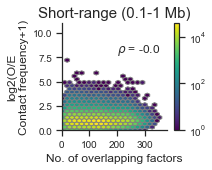

In [53]:
cm = 1/2.54
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":15, 
                                "axes.labelsize":12, "xtick.labelsize": 10,
                                "ytick.labelsize": 10})  
fig, ax = plt.subplots(figsize=(6*cm,5*cm))
r, pvalue = scipy.stats.spearmanr(overlaps_short["n_overlap"], overlaps_short["log2_contact"])
g = ax.hexbin(overlaps_short["n_overlap"], 
              overlaps_short["log2_contact"],
              gridsize=20, edgecolors='grey', 
              cmap='viridis', mincnt=1,
              bins='log')
ax.set_axisbelow(True)
ax.set_xlabel('No. of overlapping factors')
ax.set_ylabel('log2(O/E\nContact frequency+1)')
ax.set_title("Short-range (0.1-1 Mb)")
ax.set_xlim([0, 380])
ax.set_ylim([0, 11])
ax.set_xticks([0, 100, 200, 300])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
cb = fig.colorbar(g, ax=ax)
plt.text(200, 8, str(r'$\rho$' + f' = {r:.1f}'), 
       horizontalalignment='left',
       fontsize=12)
plt.savefig("plots/mESC_shortrange_nrpeaks_corr.svg", bbox_inches='tight')

In [51]:
overlaps_long = pd.merge(pd.merge(contact_freq.loc[contact_freq["distance_band"] == "1000000, 10000000"], n_overlap_1), n_overlap_2)
overlaps_long["n_overlap"] = overlaps_long["n_overlap_1"] + overlaps_long["n_overlap_2"]

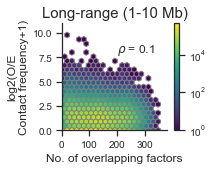

In [52]:
cm = 1/2.54
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":15, 
                                "axes.labelsize":12, "xtick.labelsize": 10,
                                "ytick.labelsize": 10})  
fig, ax = plt.subplots(figsize=(6*cm,5*cm))
r, pvalue = scipy.stats.spearmanr(overlaps_long["n_overlap"], overlaps_long["log2_contact"])
g = ax.hexbin(overlaps_long["n_overlap"], 
              overlaps_long["log2_contact"],
              gridsize=20, edgecolors='grey', 
              cmap='viridis', mincnt=1,
              bins='log')
ax.set_axisbelow(True)
ax.set_xlabel('No. of overlapping factors')
ax.set_ylabel('log2(O/E\nContact frequency+1)')
ax.set_title("Long-range (1-10 Mb)")
ax.set_xlim([0, 380])
ax.set_ylim([0, 11])
ax.set_xticks([0, 100, 200, 300])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
cb = fig.colorbar(g, ax=ax)
plt.text(200, 8, str(r'$\rho$' + f' = {r:.1f}'), 
       horizontalalignment='left',
       fontsize=12)
plt.savefig("plots/mESC_longrange_nrpeaks_corr.svg", bbox_inches='tight')